In [1]:
!pip install matplotlib --upgrade
!pip install nibabel --upgrade
!pip install nilearn
import numpy as np
import os
from scipy import io as sio
from scipy import stats
import pandas as pd
import torch
from IPython.display import Image 
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Mount Google drive

In [2]:
# Mount your Google drive to the Google colab notebook 
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/KNU_2023_FC_classification')

Mounted at /content/drive


# Load saved model

In [4]:
model = torch.load('result_20230206_172749/train_rst/model_1.pt', map_location='cpu')
print(model['ext_1.weight'].shape,model['prd_1.weight'].shape,model['prd_2.weight'].shape)

torch.Size([512, 19900]) torch.Size([512, 512]) torch.Size([1, 512])


# Make weight feature map from weight parameters

In [5]:
# Weight feature is multiplying weight matrices across layers
WF = torch.matmul(model['ext_1.weight'].T, model['prd_1.weight'].T) 
WF = torch.matmul(WF, model['prd_2.weight'].T)
WF = np.array(WF).squeeze()

# Visualize on 2D matrix

In [6]:
n_rois =  200
# Mapping from 1D to 2D (1 x 200*199/2)  = 1 x 19900
upper_tri_idx=np.triu(np.ones((n_rois,n_rois),dtype=np.float32),k=1)

WF_2d = np.zeros((n_rois,n_rois))
WF_2d[np.where(upper_tri_idx==1)] = WF 
WF_2d = WF_2d+WF_2d.T

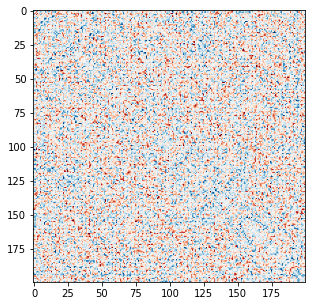

In [8]:
plt.figure(figsize=(5,5))
plt.imshow(WF_2d,cmap='RdBu_r',vmin=-0.06,vmax=0.06)
plt.show()

# Sort order of ROIs by 7 network

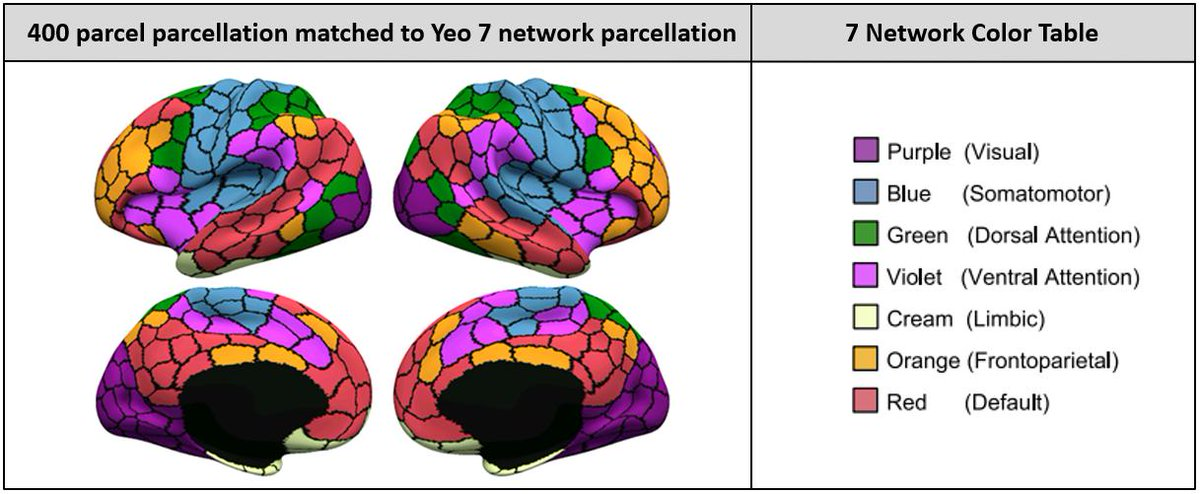

In [9]:
Image("7network.jpg")

In [10]:
network_info = np.load('7network_order.npz')
network_label, network_orderidx, network_length = network_info['label'], network_info['order_idx'], network_info['length']

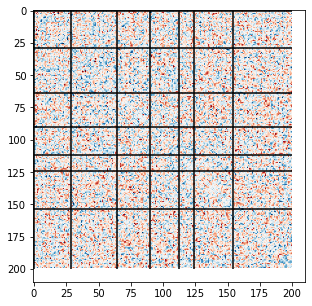

In [13]:
WF_2d_sort = WF_2d[network_orderidx,:]
WF_2d_sort = WF_2d_sort[:,network_orderidx]

plt.figure(figsize=(5,5))
plt.imshow(WF_2d_sort,cmap='RdBu_r',vmin=-0.06,vmax=0.06)
for net in range(7):
    plt.hlines(y=np.sum(network_length[:net]),xmin=0,xmax=n_rois,color='k')
    plt.vlines(x=np.sum(network_length[:net]),ymin=0,ymax=n_rois,color='k')
plt.show()

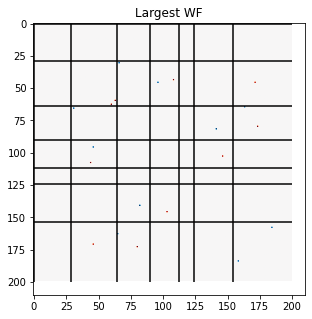

In [20]:
pct_thr = 99.95
abs_thr = np.percentile(np.abs(WF),pct_thr)

plt.figure(figsize=(5,5))
plt.imshow(WF_2d_sort*(np.abs(WF_2d_sort)>=abs_thr),cmap='RdBu_r',vmin=-thr,vmax=thr)
for net in range(7):
    plt.hlines(y=np.sum(network_length[:net]),xmin=0,xmax=n_rois,color='k')
    plt.vlines(x=np.sum(network_length[:net]),ymin=0,ymax=n_rois,color='k')
plt.title('Largest WF')
plt.show()

# Visualize on 3D brain space

In [18]:
from nilearn import datasets
from nilearn import plotting
from nilearn import image

atlas_schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, yeo_networks=7, resolution_mm=2)
coord_schaefer = plotting.find_parcellation_cut_coords(atlas_schaefer['maps'])
roi_net_info = pd.read_table('7networks_info.txt',names=['index','name','R','G','B','etc'])
roi_RGB = np.vstack([roi_net_info['R'].to_numpy(),roi_net_info['G'].to_numpy(),roi_net_info['B'].to_numpy()]).T/255

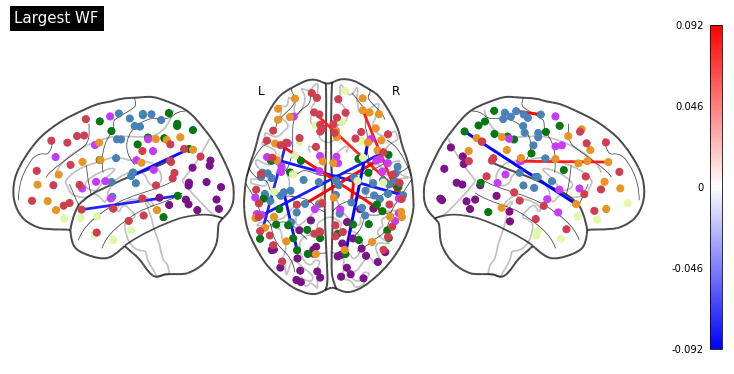

In [21]:
fig = plt.figure(figsize=(10,5))
plotting.plot_connectome(WF_2d*(np.abs(WF_2d)>=abs_thr), coord_schaefer, figure=fig, title='Largest WF',
                         display_mode='lzr', node_color=roi_RGB, node_size=50, colorbar=True)
plotting.show()

In [22]:
plotting.view_connectome(WF_2d*(np.abs(WF_2d)>=abs_thr), coord_schaefer, title='Largest WF', colorbar=True) 

Output hidden; open in https://colab.research.google.com to view.